# Voronoi Graphs

In [1]:
# Make the relevant imports including Voronoi methods
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
%matplotlib inline 


In [2]:
plt.rcParams["figure.figsize"] = [12, 12]

In [4]:

# Recreate the figure above for a new set of random points
points = np.random.randint(50, size=(50, 2))
print(points[:5,])

graph = Voronoi(points)

[[47 48]
 [28 30]
 [35 38]
 [10 27]
 [23 11]]


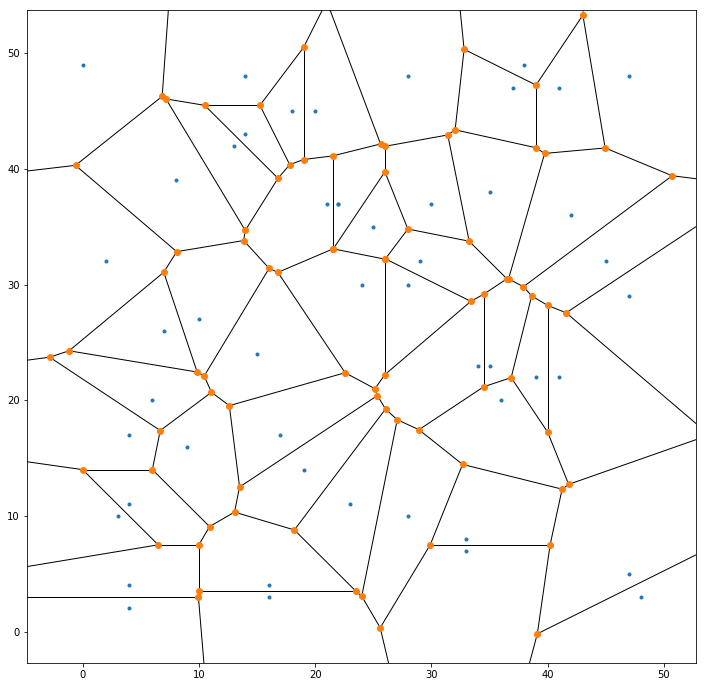

In [5]:
voronoi_plot_2d(graph)
plt.show()

In [24]:
print(graph.ridge_vertices)

[[-1, 0], [0, 1], [-1, 1], [13, 14], [13, 19], [14, 21], [19, 21], [6, 8], [6, 20], [8, 22], [20, 23], [22, 23], [-1, 26], [-1, 2], [2, 25], [25, 26], [-1, 10], [10, 11], [11, 26], [3, 28], [3, 7], [7, 9], [9, 30], [28, 31], [30, 31], [0, 34], [1, 15], [15, 33], [33, 34], [-1, 13], [14, 35], [34, 35], [40, 42], [40, 41], [41, 42], [6, 17], [7, 40], [8, 9], [17, 38], [36, 38], [36, 42], [-1, 45], [-1, 43], [43, 45], [19, 46], [20, 21], [23, 44], [44, 46], [45, 46], [47, 51], [47, 48], [48, 49], [49, 50], [50, 51], [25, 51], [26, 47], [11, 12], [12, 18], [18, 48], [18, 39], [36, 39], [41, 49], [3, 5], [5, 50], [2, 4], [4, 5], [-1, 52], [10, 53], [52, 53], [12, 24], [24, 54], [53, 54], [56, 57], [56, 58], [57, 59], [58, 59], [4, 56], [28, 57], [-1, 16], [16, 58], [31, 32], [32, 59], [16, 29], [29, 32], [60, 61], [60, 63], [61, 62], [62, 64], [63, 64], [29, 60], [30, 61], [43, 63], [22, 62], [44, 64], [65, 67], [65, 66], [66, 68], [67, 68], [24, 65], [39, 66], [37, 38], [37, 68], [15, 27],

In [6]:
# Read in the obstacle data
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


In [7]:
# If you want to use the prebuilt bresenham method
# Import the Bresenham package
from bresenham import bresenham

In [11]:
# Here you'll modify the `create_grid()` method from a previous exercise
# In this new function you'll record obstacle centres and
# create a Voronoi graph around those points
def create_grid_and_edges(data, drone_altitude, safety_distance):
    """
    Returns a grid representation of a 2D configuration space
    along with Voronoi graph edges given obstacle data and the
    drone's altitude.
    """

    # minimum and maximum north coordinates
    north_min = np.floor(np.min(data[:, 0] - data[:, 3]))
    north_max = np.ceil(np.max(data[:, 0] + data[:, 3]))

    # minimum and maximum east coordinates
    east_min = np.floor(np.min(data[:, 1] - data[:, 4]))
    east_max = np.ceil(np.max(data[:, 1] + data[:, 4]))

    # given the minimum and maximum coordinates we can
    # calculate the size of the grid.
    north_size = int(np.ceil((north_max - north_min)))
    east_size = int(np.ceil((east_max - east_min)))

    # Initialize an empty grid
    grid = np.zeros((north_size, east_size))
    
    # Center offset for grid
    north_min_center = np.min(data[:, 0])
    east_min_center = np.min(data[:, 1])
    
    # Define a list to hold Voronoi points
    points = []
    
    # Populate the grid with obstacles
    for i in range(data.shape[0]):
        north, east, alt, d_north, d_east, d_alt = data[i, :]

        if alt + d_alt + safety_distance > drone_altitude:
            obstacle = [
                int(north - d_north - safety_distance - north_min_center),
                int(north + d_north + safety_distance - north_min_center),
                int(east - d_east - safety_distance - east_min_center),
                int(east + d_east + safety_distance - east_min_center),
            ]
            grid[obstacle[0]:obstacle[1]+1, obstacle[2]:obstacle[3]+1] = 1
            
            # add center of obstacles to points list
            points.append([north - north_min, east - east_min])

    # TODO: create a voronoi graph based on
    # location of obstacle centres
    graph = Voronoi(points)
    
    # TODO: check each edge from graph.ridge_vertices for collision    
    edges = []           
    for v in graph.ridge_vertices:
        v1 = graph.vertices[v[0]]
        v2 = graph.vertices[v[1]]
        
        if np.amin(v1) < 0 or np.amin(v2)< 0 or v1[0] > grid.shape[0] or v1[1] > grid.shape[1] or v2[0] > grid.shape[0] or v2[1] > grid.shape[1]:
            continue
        
        bpoints = list(bresenham(int(v1[0]), int(v1[1]), int(v2[0]), int(v2[1])))
        hit = False
        for p in bpoints:
            if grid[p[0], p[1]] == 1:
                hit = True
                break

        if not hit:
            edge = (tuple(v1), tuple(v2))
            edges.append(edge)
    
    return grid, edges

In [12]:
# Define a flying altitude (feel free to change this)
drone_altitude = 5
safety_distance = 3
grid, edges = create_grid_and_edges(data, drone_altitude, safety_distance)
print('Found %5d edges' % len(edges))

Found  1436 edges


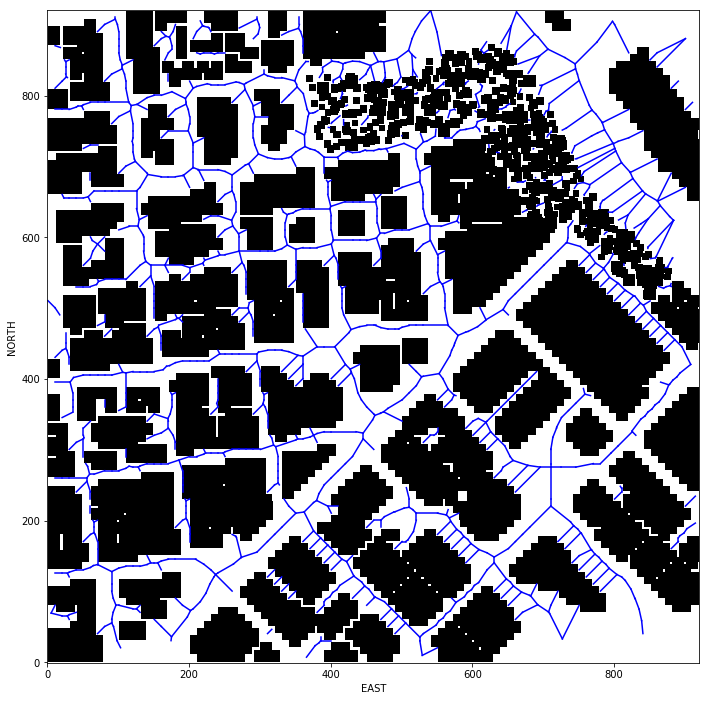

In [13]:
# equivalent to
# plt.imshow(np.flip(grid, 0))
# Plot it up!
plt.imshow(grid, origin='lower', cmap='Greys') 

# Stepping through each edge
for e in edges:
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

[solution](/notebooks/Voronoi-Solution.ipynb)